In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [41]:
df = pd.read_csv('combined_file.csv')
pd.set_option('display.max_columns', None)

C:\Users\New\AppData\Local\Temp\ipykernel_22560\3579430954.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_file.csv')


DATA CLEANING

In [42]:
# extract only numbers
df['km'] = df['km'].astype(str)
df['km'] = df['km'].str.replace(",","")
df['km'] = pd.to_numeric(df['km'])

#price convert to int 
def convert_to_int(value):
    if pd.isna(value):
        return None  
    value = value.replace('₹', '').strip()

    if 'Lakh' in value:
        value = value.replace('Lakh', '').strip()
        multiplier = 1e5  
    elif 'Crore' in value:
        value = value.replace('Crore', '').strip()
        multiplier = 1e7 
    else:
        multiplier = 1  

    value = value.replace(',', '')

    try:
        return int(float(value) * multiplier)
    except ValueError:
        return None 


# Apply the function to the 'price' column
df['price'] = df['price'].apply(convert_to_int)

df['seating_capacity'] = df['seating_capacity'].fillna(0).astype(int)

df['wheel_base'] = df['wheel_base'].astype(str)
df['wheel_base'] = df['wheel_base'].str.extract(r'(\d+)')  
df['wheel_base'] = pd.to_numeric(df['wheel_base'])
df['wheel_base'] = df['wheel_base'].fillna(df['wheel_base'].mean()).astype(int)

df['gear_box'] = df['gear_box'].astype(str)
df['gear_box'] = df['gear_box'].str.extract(r'(\d+)')  
df['gear_box'] = pd.to_numeric(df['gear_box'])
df['gear_box'] = df['gear_box'].fillna(df['gear_box'].mean()).astype(int)


COLUMN SELECTION

In [43]:
columns_to_keep = [
    'city','ft', 'bt', 'km', 'transmission', 'ownerno', 'model', 
    'modelyear','wheel_base','gear_box','price','top_features', 'color','insurance_validity','rto'
]
#
# Creating a new DataFrame with only the specified columns
df_filtered = df[columns_to_keep]

STANDARD SCALAR FOR NORMALISATION

In [44]:
categorical_cols = df_filtered.select_dtypes(include=[object]).columns

le = LabelEncoder()
for column in categorical_cols:
    df_filtered[column] = le.fit_transform(df_filtered[column])

C:\Users\New\AppData\Local\Temp\ipykernel_22560\289534916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = le.fit_transform(df_filtered[column])
C:\Users\New\AppData\Local\Temp\ipykernel_22560\289534916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = le.fit_transform(df_filtered[column])
C:\Users\New\AppData\Local\Temp\ipykernel_22560\289534916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [45]:
df_filtered

,city,ft,bt,km,transmission,ownerno,model,modelyear,wheel_base,gear_box,price,top_features,color,insurance_validity,rto
0,0,4,2,120000,1,3,160,2015,2425,5,400000,128,138,5,165
1,0,4,7,32706,1,2,50,2018,2519,5,811000,78,138,2,135
2,0,4,2,11949,1,1,273,2018,2400,5,585000,78,110,2,133
3,0,4,8,17794,1,1,87,2014,2425,5,462000,78,86,2,167
4,0,1,7,60000,1,1,178,2015,2600,5,790000,80,55,5,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,5,4,2,10000,1,1,160,2022,2435,5,509999,154,86,5,464
8365,5,4,2,120000,1,1,155,2014,2360,5,180000,143,86,5,464
8366,5,4,8,50000,0,3,197,2011,2760,7,550000,71,86,5,413
8367,5,4,2,40000,1,1,175,2012,2360,5,140000,78,86,5,464


In [46]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   city                8369 non-null   int32
 1   ft                  8369 non-null   int32
 2   bt                  8369 non-null   int32
 3   km                  8369 non-null   int64
 4   transmission        8369 non-null   int32
 5   ownerno             8369 non-null   int64
 6   model               8369 non-null   int32
 7   modelyear           8369 non-null   int64
 8   wheel_base          8369 non-null   int32
 9   gear_box            8369 non-null   int32
 10  price               8369 non-null   int64
 11  top_features        8369 non-null   int32
 12  color               8369 non-null   int32
 13  insurance_validity  8369 non-null   int32
 14  rto                 8369 non-null   int32
dtypes: int32(11), int64(4)
memory usage: 621.3 KB


imputation

In [47]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer

df = df_filtered
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Apply KNNImputer to numeric columns
imputer = KNNImputer(n_neighbors=3)
df_numeric = df[numeric_cols]
df_numeric_imputed = imputer.fit_transform(df_numeric)
df_numeric_imputed = pd.DataFrame(df_numeric_imputed, columns=numeric_cols)

df_imputed = pd.concat([df_numeric_imputed], axis=1)
df_imputed = df_imputed[df.columns]

df_imputed.head(2)


,city,ft,bt,km,transmission,ownerno,model,modelyear,wheel_base,gear_box,price,top_features,color,insurance_validity,rto
0,0.0,4.0,2.0,120000.0,1.0,3.0,160.0,2015.0,2425.0,5.0,400000.0,128.0,138.0,5.0,165.0
1,0.0,4.0,7.0,32706.0,1.0,2.0,50.0,2018.0,2519.0,5.0,811000.0,78.0,138.0,2.0,135.0


fLOAT TO INT CONVERSION

In [48]:
for col in df_imputed.columns:
    df_imputed[col] = df_imputed[col].astype(int)

TEST TRAIN SPLITUP

In [49]:
X = df_imputed.iloc[:,:-1].values
y = df_imputed.iloc[:,-1].values

X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=42,test_size=0.2)

Mode => LinearRegression

In [50]:
model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# print(pd.DataFrame(np.round(y_pred),y_test).reset_index())

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", np.round(mae))
print("Mean Squared Error:", np.round(mse))
print("R-squared:", r2)

Mean Absolute Error: 100.0
Mean Squared Error: 15095.0
R-squared: 0.20492182245961543


Outliyer deduction

In [51]:
import pandas as pd
columns = df_imputed.columns

# Create a mask to filter out outliers
mask = pd.Series([True] * len(df_imputed))

for column in columns:
    Q1 = df_imputed[column].quantile(0.25)
    Q3 = df_imputed[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Update mask to identify non-outlier rows
    column_mask = (df_imputed[column] >= lower_bound) & (df_imputed[column] <= upper_bound)
    mask = mask & column_mask

# Filter the DataFrame to remove outliers
cleaned_df = df_imputed[mask].reset_index(drop=True)

cleaned_df.head(5)


,city,ft,bt,km,transmission,ownerno,model,modelyear,wheel_base,gear_box,price,top_features,color,insurance_validity,rto
0,0,4,2,120000,1,3,160,2015,2425,5,400000,128,138,5,165
1,0,4,7,32706,1,2,50,2018,2519,5,811000,78,138,2,135
2,0,4,2,11949,1,1,273,2018,2400,5,585000,78,110,2,133
3,0,4,8,17794,1,1,87,2014,2425,5,462000,78,86,2,167
4,0,1,7,60000,1,1,178,2015,2600,5,790000,80,55,5,134


In [58]:
cleaned_df.shape

(7001, 15)

Random Forests

Mean Absolute Error: 58.12131690561529
Mean Squared Error: 9521.338417918874
R-squared: 0.498498779200947

Feature Importance:
               Feature  Importance
0                 city    0.429114
7            modelyear    0.096603
10               price    0.091572
3                   km    0.075638
6                model    0.062194
11        top_features    0.053017
8           wheel_base    0.051149
13  insurance_validity    0.037219
12               color    0.032398
5              ownerno    0.026988
2                   bt    0.014561
9             gear_box    0.011995
1                   ft    0.011257
4         transmission    0.006295


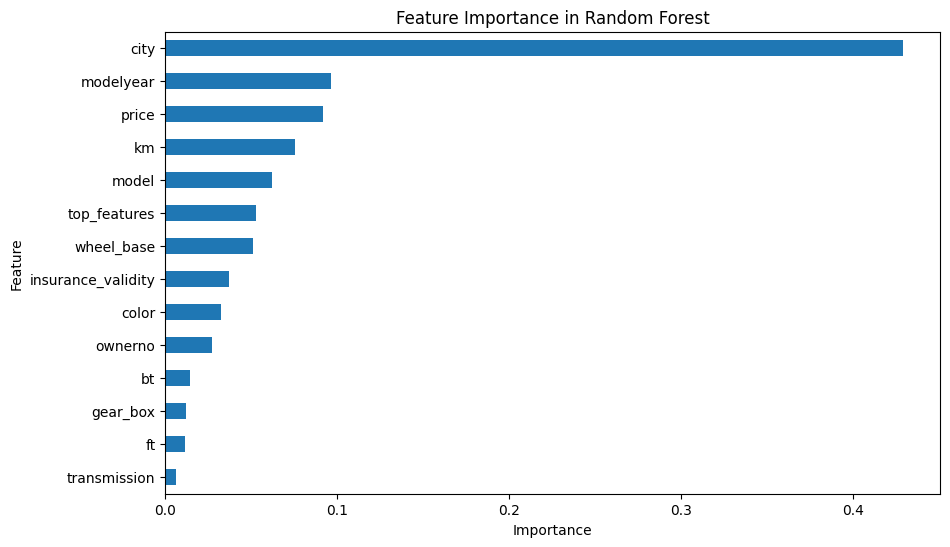

In [52]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Get feature importance
feature_importances = model.feature_importances_
feature_names = cleaned_df.columns[:-1]

# Create a DataFrame to view feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plotting feature importance
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


model => GradientBoostingRegressor

Mean Absolute Error: 62.22375810443196
Mean Squared Error: 9323.39054626426
R-squared: 0.5089249498643632

Feature Importance:
               Feature  Importance
0                 city    0.691988
7            modelyear    0.094404
13  insurance_validity    0.049466
10               price    0.033921
3                   km    0.027819
12               color    0.021402
6                model    0.018948
8           wheel_base    0.017842
11        top_features    0.016066
5              ownerno    0.015529
1                   ft    0.004464
9             gear_box    0.003875
2                   bt    0.003260
4         transmission    0.001016


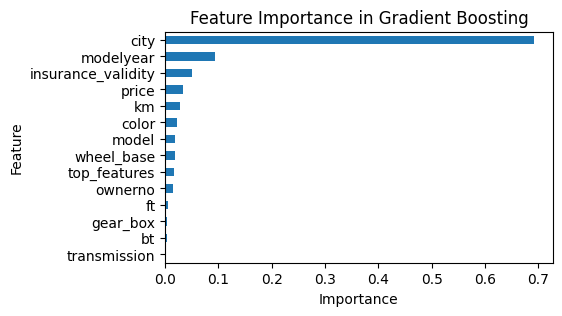

In [53]:
# Initialize and train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Get feature importance
feature_importances = model.feature_importances_
feature_names = cleaned_df.columns[:-1]

# Create a DataFrame to view feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plotting feature importance
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(5, 3))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Mean Absolute Error: 60.76287547964765
Mean Squared Error: 9101.098972189857
R-squared: 0.5206333348495933

Feature Importance:
               Feature  Importance
0                 city    0.740504
7            modelyear    0.103875
13  insurance_validity    0.057296
10               price    0.017409
5              ownerno    0.016339
12               color    0.015101
3                   km    0.012276
6                model    0.010858
11        top_features    0.009975
8           wheel_base    0.009960
1                   ft    0.003114
2                   bt    0.001603
9             gear_box    0.001215
4         transmission    0.000476


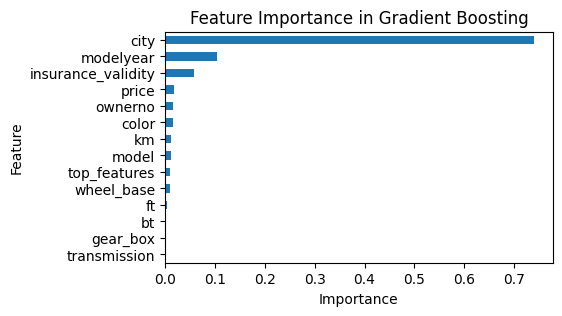

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Parameters:", grid_search.best_params_)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Get feature importance from the best model
feature_importances = best_model.feature_importances_
feature_names = cleaned_df.columns[:-1]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plotting feature importance
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(5, 3))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


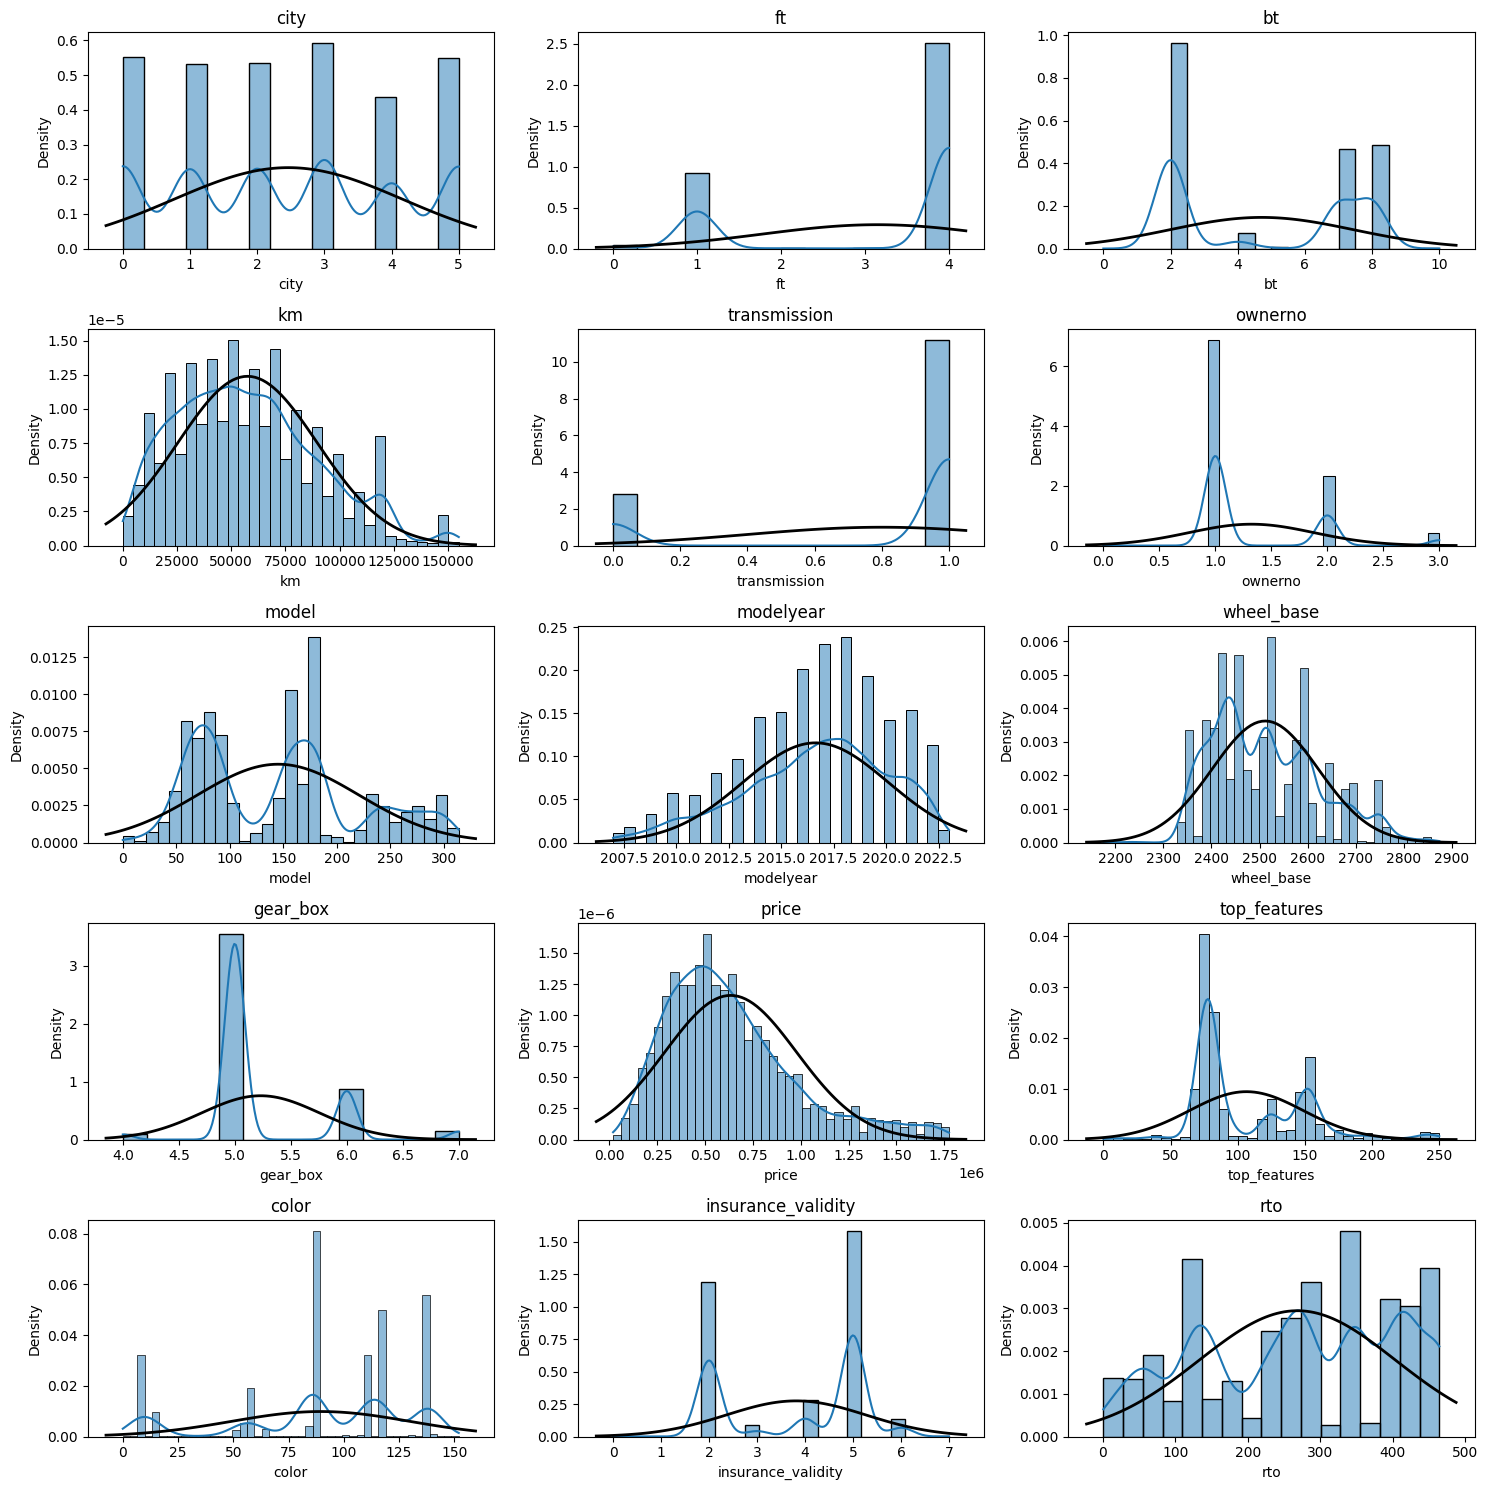

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

data = cleaned_df
# Plot histograms with normal distribution fit
columns = data.columns
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

for i, column in enumerate(columns):
    sns.histplot(data[column], kde=True, ax=axes[i//3, i%3], stat="density")
    mu, std = norm.fit(data[column])
    xmin, xmax = axes[i//3, i%3].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i//3, i%3].plot(x, p, 'k', linewidth=2)
    axes[i//3, i%3].set_title(f'{column}')
    axes[i//3, i%3].set_ylabel('Density')

plt.tight_layout()
plt.show()


Mean Absolute Error: 53.256074836001495
Mean Squared Error: 8341.872820854527
R-squared: 0.542681669802973

Feature Importance:
               Feature  Importance
0                 city    0.478234
7            modelyear    0.089889
10               price    0.085109
3                   km    0.076061
11        top_features    0.050145
6                model    0.048870
8           wheel_base    0.046392
12               color    0.032411
13  insurance_validity    0.031579
5              ownerno    0.019049
2                   bt    0.014661
9             gear_box    0.011227
1                   ft    0.009778
4         transmission    0.006595


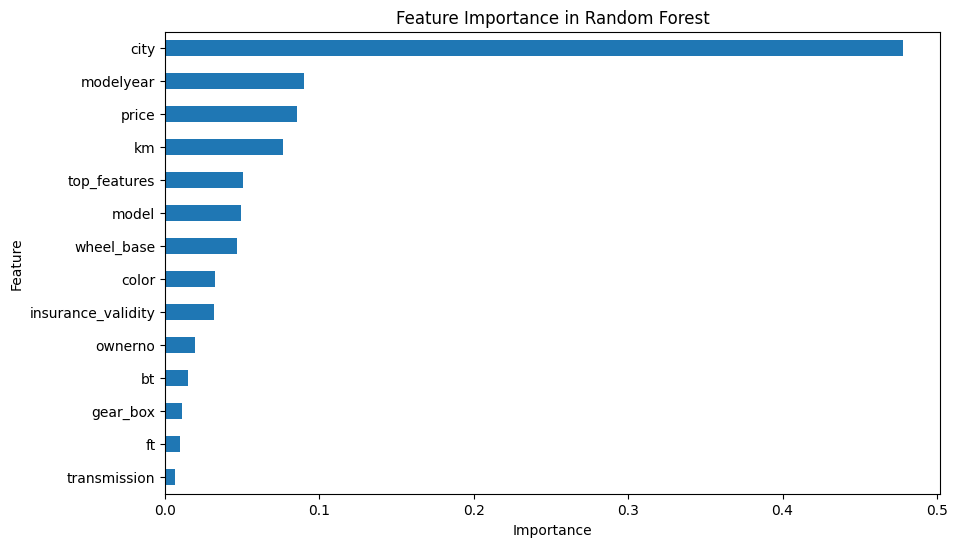

In [56]:
from sklearn.ensemble import RandomForestRegressor
# Assume cleaned_df is your DataFrame
X = cleaned_df.iloc[:, :-1].values
y = cleaned_df.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Get feature importance
feature_importances = model.feature_importances_
feature_names = cleaned_df.columns[:-1]

# Create a DataFrame to view feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plotting feature importance
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


In [57]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv('final_cleaned.csv')
df.drop(columns=["Unnamed: 0"],inplace=True)

# Fit and store label encoders for categorical columns
categorical_cols = df.select_dtypes(include=[object]).columns
for column in categorical_cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=42,test_size=0.2)    

model = GradientBoostingRegressor(n_estimators=300, random_state=42,learning_rate = 0.2, max_depth = 5, min_samples_leaf = 4, min_samples_split = 2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)